# Analysing the Order Book for stop levels

Using the Bitmex API we can analyse the order books. The goal of this is to find peak levels of buy and sell orders.
Due to the frequency of our trading system, we will need to find a suitable percentile of orders both higher and lower in range from the current price.
Using this range of data we can find where the majority of the orders volume are, and which peaks are closest to where we are trading to update date our stop-loss or liquidation levels accordingly.

This notebbok is seperated into tthe following parts:

- [Part 0. Import Libraries](#part-0.-import-libraries)
- [Part 1. Test Order Book Data](#part-1.-test-order-book-data)
- [Part 2. Get the OrderBook Data by Percentiles](#part-2.-get-the-orderBook-data-by-percentiles)
- [Part 3. Find the Peaks in Data Range](#part-3.-find-the-peaks-in-data-range)



---

# Part 0. Import Libraries

Import Libraries and set global variables

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import requests
from typing import List, Dict

from scipy.signal import find_peaks, peak_prominences
from scipy.stats import iqr

%matplotlib inline
plt.rcParams['figure.figsize'] = [17, 7]

contract = "XBTUSD"

---
# Part 1. Test Order Book Data

### Get Order Book Data

In [2]:
def orderbook_data(depth: int, contract: str = "ETHUSD", raw_data=False):

    url = "https://www.bitmex.com/api/v1/orderBook/L2"
    book_data = {'buys': 0, 'sells': 0}
    raw_book_data = {'total_buys': 0, 'sum_of_buys': 0, 'furthest_5_buy_prices': [],
                    'total_sells': 0, 'sum_of_sells': 0, 'furthest_5_sell_prices': []}


    # Set inputs
    data = dict()
    data['symbol'] = contract
    data['depth'] = depth

    try:
        response = requests.get(url, params=data)
    except Exception as e:
        print(f"Connecton error while making GET request to {url}: {e}")
        return

    if response.status_code == 200:
        response_data = response.json()
    else:
        print(f"Error while making GET request to {url}: {response.status_code}")
        print(response.headers)
        return None
    
    if response_data is not None:
        if raw_data:
            for idx, data in enumerate(response_data):

                if idx < 5:
                    raw_book_data['furthest_5_sell_prices'].append(data['price'])

                if idx > len(response_data)-6:
                    raw_book_data['furthest_5_buy_prices'].append(data['price'])

                if data['side'] == "Buy":
                    raw_book_data["sum_of_buys"] += data["size"]
                    raw_book_data['total_buys'] += 1

                elif data['side'] == "Sell":
                    raw_book_data["sum_of_sells"] += data["size"]
                    raw_book_data['total_sells'] += 1

            return raw_book_data

        else:
            for data in response_data:
                if data['side'] == "Buy":
                    book_data["buys"] += data["size"]

                elif data['side'] == "Sell":
                    book_data["sells"] += data["size"]
    
            return book_data

### Get current price

Gets the current price of the selected contract

In [3]:
def get_curr_price(contract: str) -> str:

    url = "https://www.bitmex.com/api/v1/trade/bucketed"

    data = dict()
    data['symbol'] = contract
    data['partial'] = True  # returns a candle if it is not finished yet
    data['binSize'] = '1m'
    data['count'] = 1   # how many candles we can return (500 max)
    data['reverse'] = True

    try:
        response = requests.get(url, params=data)
    except Exception as e:
        print(f"Connecton error while making GET request to {url}: {e}")
        return

    if response.status_code == 200:
        raw_candles = response.json()
    else:
        print(f"Error while making GET request to {url}: {response.status_code}")
        print(response.headers)
        return None
    
    if raw_candles is not None:
        return raw_candles[0]['close']

### Get Size of the OrderBook

Run some stats on the entire orderbook

In [4]:
book_size = orderbook_data(0, contract, raw_data=True)
book_size_avg = (book_size["total_buys"] + book_size["total_sells"]) // 2

curr_price = get_curr_price(contract)

ret = "Buyers" if book_size["total_buys"] > book_size["total_sells"] else "sellers"

if ret == "Buyers":
    amount = book_size["total_buys"] - book_size["total_sells"]
else:
    amount = book_size["total_sells"] - book_size["total_buys"]


print(f"\nCurrent {contract} price: ${curr_price:,.2f}")

print(f"\nThe average size of the order book for {contract} is: {book_size_avg}")
print(f"There are {amount} more orders from {ret}")

print(f'\nTotal orderbook size: {book_size["total_buys"]+book_size["total_sells"]}')
print(f'Total buys: {book_size["total_buys"]}')
print(f'Total sells: {book_size["total_sells"]}')

print(f"\nTotal buy orderbook volume: ${book_size['sum_of_buys']:,.2f}")
print(f"Total sell orderbook volume: ${book_size['sum_of_sells']:,.2f}")

print('\nFurthest 5 buy prices:')
for i, v in enumerate(book_size['furthest_5_buy_prices']):
    print(f"{i+1} => ${v:,.2f}")

print('\nFurthest 5 sell prices:')
for i, v in enumerate(book_size['furthest_5_sell_prices'][::-1]):
    print(f"{i+1} => ${v:,.2f}")


Current XBTUSD price: $20,080.00

The average size of the order book for XBTUSD is: 2739
There are 1184 more orders from sellers

Total orderbook size: 5478
Total buys: 2147
Total sells: 3331

Total buy orderbook volume: $72,541,600.00
Total sell orderbook volume: $105,717,700.00

Furthest 5 buy prices:
1 => $30.00
2 => $10.00
3 => $1.50
4 => $1.00
5 => $0.50

Furthest 5 sell prices:
1 => $573,000.00
2 => $657,700.00
3 => $658,900.00
4 => $662,520.00
5 => $1,000,000.00


As we can see from the furthest five buy and sell prices, they are at very extreme levels in comparision to the current price.
Knowing this it becomes obvious we can't use the entire order book for analysis as the outliars will screw our data.

The next idea will be to get different percentile ranges for the first 50% of depth in the order book in both direction (buy / sell) to find the correct slice for our system to perform optimally.

---
# Part 2. Get the OrderBook Data by Percentiles

### Get data

This time we will pass the variable $k$, a percentile to dictate how far from the current price we want to retrive order book data.
we pass ```orderbook_data_by_percentile``` in a loop with 5% increasing levels of $k$ starting at 5% until 50%.

In [5]:
def orderbook_data_by_percentile(k_buy: float, k_sell: float, contract: str = "ETHUSD", raw_data=False):

    url = "https://www.bitmex.com/api/v1/orderBook/L2"

    raw_book_data = {'total_buys': 0, 'sum_of_buys': 0, 'total_sells': 0, 'sum_of_sells': 0}
    raw_sell_nodes = {"size": [], "price": []}
    raw_buy_nodes = {"size": [], "price": []}


    # Set inputs
    data = dict()
    data['symbol'] = contract
    data['depth'] = 0

    try:
        response = requests.get(url, params=data)

    except Exception as e:
        print(f"Connecton error while making GET request to {url}: {e}")
        return

    if response.status_code == 200:
        response_data = response.json()

    else:
        print(f"Error while making GET request to {url}: {response.status_code}")
        print(response.headers)
        return None
    
    if response_data is not None:

        for idx, data in enumerate(response_data):

            if data['side'] == "Buy":
                if data['price'] > k_buy:
                    raw_book_data["sum_of_buys"] += data["size"]
                    raw_book_data['total_buys'] += 1

                    if raw_data:
                        raw_buy_nodes['size'].append(data['size'])
                        raw_buy_nodes['price'].append(data['price'])

            elif data['side'] == "Sell":
                if data['price'] < k_sell:
                    raw_book_data["sum_of_sells"] += data["size"]
                    raw_book_data['total_sells'] += 1

                    if raw_data:
                        raw_sell_nodes['size'].append(data['size'])
                        raw_sell_nodes['price'].append(data['price'])

        if raw_data:
            return raw_book_data, raw_buy_nodes, raw_sell_nodes
        return raw_book_data


We can store the collected data for each 5% above and below the current price and store the results in a Pandas ```DataFrame```

In [6]:
curr_price = get_curr_price(contract)
df_data = []
percentile, idx = 0.05, 0

while percentile <= 0.5:
    k_buy = curr_price - (curr_price * percentile)
    k_sell = curr_price + (curr_price * percentile)

    book_data = orderbook_data_by_percentile(k_buy, k_sell, contract)

    df_data.append([f"{round(percentile*100)}%", book_data['total_buys'], book_data['total_sells'],
                    f"${book_data['sum_of_buys']:,.2f}", f"${book_data['sum_of_sells']:,.2f}",
                    f"${abs(book_data['sum_of_sells']-book_data['sum_of_buys']):,.2f}"])

    percentile += 0.05
    idx == 1

df = pd.DataFrame(df_data, columns=["%_from_current_price", "total_buy_orders", "total_sell_orders",
                                    "Buy_volume", "sell_volume", "Difference"])
df.set_index('%_from_current_price', inplace=True)

print(f"Current price: {curr_price}")
df

Current price: 20080


,total_buy_orders,total_sell_orders,Buy_volume,sell_volume,Difference
%_from_current_price,,,,,
5%,684,616,"$23,596,000.00","$25,368,400.00","$1,772,400.00"
10%,1097,998,"$28,887,800.00","$32,022,400.00","$3,134,600.00"
15%,1375,1220,"$35,766,600.00","$34,850,700.00","$915,900.00"
20%,1559,1322,"$44,077,500.00","$36,087,800.00","$7,989,700.00"
25%,1675,1411,"$49,420,500.00","$47,820,300.00","$1,600,200.00"
30%,1764,1486,"$62,738,500.00","$55,516,800.00","$7,221,700.00"
35%,1845,1579,"$72,631,200.00","$64,264,100.00","$8,367,100.00"
40%,1914,1688,"$74,662,100.00","$81,462,200.00","$6,800,100.00"
45%,1962,1771,"$75,764,000.00","$84,480,300.00","$8,716,300.00"


5% seems to be the optimal level due to it holding the highest amount of buys / sells, and the frequency our system is trading on.

---

# Part 3. Find the Peaks in Data Range

Collect the order book data and build two ```DataFrame```'s from the buy and sell sides

In [94]:
curr_price = get_curr_price(contract)
df_data = []
percentile = 0.05

k_buy = curr_price - (curr_price * percentile)
k_sell = curr_price + (curr_price * percentile)

book_data, raw_buy_nodes, raw_sell_nodes = orderbook_data_by_percentile(k_buy, k_sell, contract, raw_data=True)

buy_orders_df = pd.DataFrame({"size": raw_buy_nodes['size'], "price": raw_buy_nodes['price']})
sell_orders_df = pd.DataFrame({"size": raw_sell_nodes['size'], "price": raw_sell_nodes['price']})

buy_orders_df.head()

,size,price
0,29300,21695.0
1,10000,21693.5
2,5600,21692.5
3,49000,21691.0
4,40200,21690.5


Using ```scipy.signal```'s ```find_peaks``` we can locates the closest noticable spikes of buy and sell orders for each given side.

- We set the distance to be: ```len(y)//```$threshold$
- we set the amount to be: ```len(y)//```$distance$

In [91]:
x_buy = buy_orders_df['price']
y_buy = buy_orders_df['size']
x_sell = sell_orders_df['price']
y_sell = sell_orders_df['size']

threshold = 3   # Required threshold of peaks, the vertical distance to its neighboring samples.
distance = 6    # Required minimal horizontal distance (>= 1) in samples between neighbouring peaks

# Peaks
buy_peaks, _ = find_peaks(y_buy, threshold=len(y_buy)//threshold, distance=len(y_buy)//distance)
sell_peaks, _ = find_peaks(y_sell, threshold=len(y_sell)//threshold, distance=len(y_sell)//distance)

sp = np.array([x_sell[i] for i in sell_peaks])
bp = np.array([x_buy[i] for i in buy_peaks])
vbp = np.array([y_sell[i] for i in sell_peaks])
vsp = np.array([y_buy[i] for i in buy_peaks])

print("Buy peaks", bp)
print("Sell peaks", sp)
print("Buy volume peaks", vsp)
print("Sell volume peaks", vbp, '\n')

print(f"Total of buy peaks ${vbp.sum():,.2f}")
print(f"Total of sell peaks ${vsp.sum():,.2f}\n")

print(f"Total of order book depth (buy side): ${y_buy.sum():,.2f}")
print(f"Total of order book depth (sell side): ${y_sell.sum():,.2f}")

print("\nIQR of buy peaks", iqr(bp))
print("IQR of sell peaks", iqr(sp))
print('-\n')


for i in sell_peaks:
    print(f"Sell orders of ${y_sell[i]:,.0f} in volume at ${x_sell[i]:,.2f}")

print(f'-\nCurrent Price: ${curr_price:,.2f}\n-')

for i in buy_peaks:
    print(f"Buy orders of ${y_buy[i]:,.0f} in volume at ${x_buy[i]:,.2f}")


Buy peaks [21455.  21282.  21093.5 20900.  20600.5]
Sell peaks [22396.5 22112.5 21726.  21565.5]
Buy volume peaks [1171000 6597500  627800 1180800  622500]
Sell volume peaks [ 416700 2000000 6735000  629800] 

Total of buy peaks $9,781,500.00
Total of sell peaks $10,199,600.00

Total of order book depth (buy side): $31,836,200.00
Total of order book depth (sell side): $31,119,800.00

IQR of buy peaks 382.0
IQR of sell peaks 497.625
-

Sell orders of $416,700 in volume at $22,396.50
Sell orders of $2,000,000 in volume at $22,112.50
Sell orders of $6,735,000 in volume at $21,726.00
Sell orders of $629,800 in volume at $21,565.50
-
Current Price: $21,511.00
-
Buy orders of $1,171,000 in volume at $21,455.00
Buy orders of $6,597,500 in volume at $21,282.00
Buy orders of $627,800 in volume at $21,093.50
Buy orders of $1,180,800 in volume at $20,900.00
Buy orders of $622,500 in volume at $20,600.50


### Plot the results


Buy Orders:

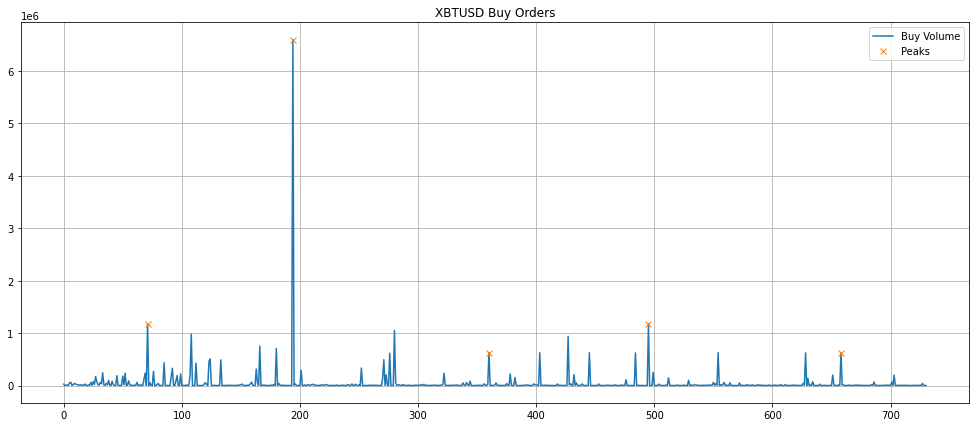

In [85]:
plt.plot([i for i in range(len(x_buy))], y_buy, label="Buy Volume")
plt.plot(buy_peaks, y_buy[buy_peaks], "x", label="Peaks")
plt.title(f'{contract} Buy Orders')
plt.grid()
plt.legend()
plt.show()

Sell Orders:

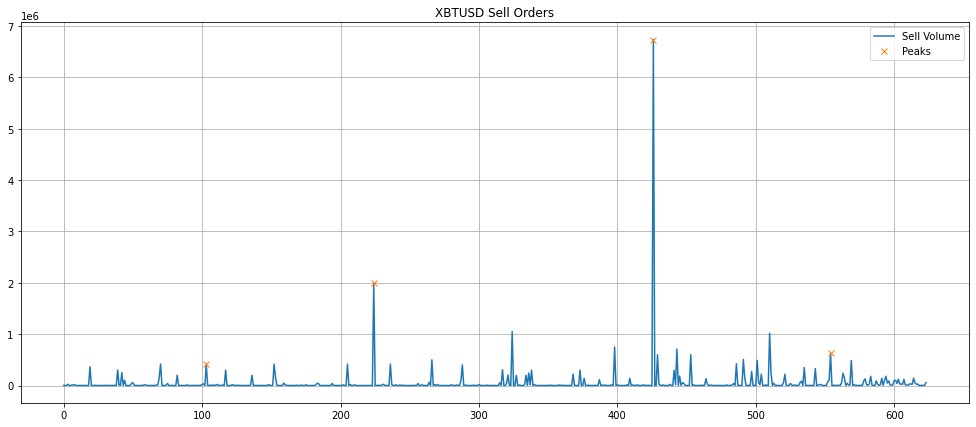

In [86]:
plt.plot([i for i in range(len(x_sell))], y_sell, label="Sell Volume")
plt.plot(sell_peaks, y_sell[sell_peaks], "x", label="Peaks")
plt.title(f'{contract} Sell Orders')
plt.grid()
plt.legend()
plt.show()

Now we know the price with the highest order volume within $n$% of the price, and the same below the current price, this will act as our anchor. 

We will re-calculate with every tick and use those two exact amounts to dynamically change the stop levels as the price approaches or moves further away. The more frequent we re-calculate, the higher the chance will be to detect spoofing in the order books.